# Real Estate competition - Kaggle
## We will focus on a random forest model, and a few variations

### Let's start by importing the necessary modules

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

import sklearn.linear_model as lm
import sklearn.cross_validation as cv
import sklearn.preprocessing as pp
from  sklearn import metrics, tree, grid_search
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/Users/Tavo/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Tavo/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using Theano backend.


In [2]:
os.getcwd()

'/Users/Tavo/Data_science'

### We read the files...

In [3]:
realestate = pd.read_csv('RealEstate/train.csv')
realestate_test = pd.read_csv('RealEstate/test.csv')

data_description = open('RealEstate/data_description.txt', 'r')
#print (data_description.read())

### Let's examine the columns and get rid of colums (1) with all null values (2) too few values

In [4]:
realestate.info()
realestate_test.info()

realestate = realestate.dropna(how='all')
realestate_test = realestate_test.dropna(how='all')


#columns withe very few values
few_values = ['Alley', 'PoolQC', 'MiscFeature']
realestate = realestate.drop(few_values, axis=1)
realestate_test = realestate_test.drop(few_values, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
print(realestate.info(), realestate.shape)
print(realestate_test.info(), realestate_test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 78 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non

### Let's change the data types of some of the columns too

In [6]:
#some columns with categorical variables are not 'object'
realestate.MSSubClass.astype('object', inplace=True)
realestate_test.MSSubClass.astype('object', inplace=True)
print('Done')

Done


### Some columns could actually be treated as quantitative variables instead of categorical. 
#### Not strictly necessary, but I wanted to try this little challenge. As you can see I had some issues with in-string variable replacement, so I found a practical solution


In [7]:
#some columns could be treated as quantitative variables
def change_scale(legend, scale, column_to_replace):
    j = 0
    for i in legend:
        command = column_to_replace + '.replace(to_replace="' + i + '"' + ', value=' + scale[j].astype('str') + ', inplace=True)'
        #print(command)        
        exec(command)
        j += 1
        if j == len(scale):
            break
    return 

legend = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
scale = np.arange(5,0,-1)
column_to_replace = 'realestate.HeatingQC'
change_scale(legend, scale, column_to_replace)
change_scale(legend, scale, 'realestate_test.HeatingQC')

legend = ['Ex', 'Gd', 'TA', 'Fa', 'Po']
scale = np.arange(5,0,-1)
column_to_replace = 'realestate.KitchenQual'
change_scale(legend, scale, column_to_replace)
change_scale(legend, scale, 'realestate_test.KitchenQual')

### Separation of the categorical and the quantitative variables

In [8]:
#Let's separate categorical from quantitative variables and make two dataframes
#Thanks to the kernel by BreadenFitz-Gerald for the idea

df = realestate
categorical = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        categorical.append(col)

df_category = df[categorical]
df_quant = df.drop(categorical, axis=1)

df_category_test = realestate_test[categorical]
df_quant_test = realestate_test.drop(categorical, axis=1)


### Correlation coefficients of the quantitative variables
#### Particularly useful if we do a linear regression, to avoid multicollinearity. In our case, we will go straight ahead with a random forest, but understanding the correlation between variables can be useful when interpreting the variable importance anyway

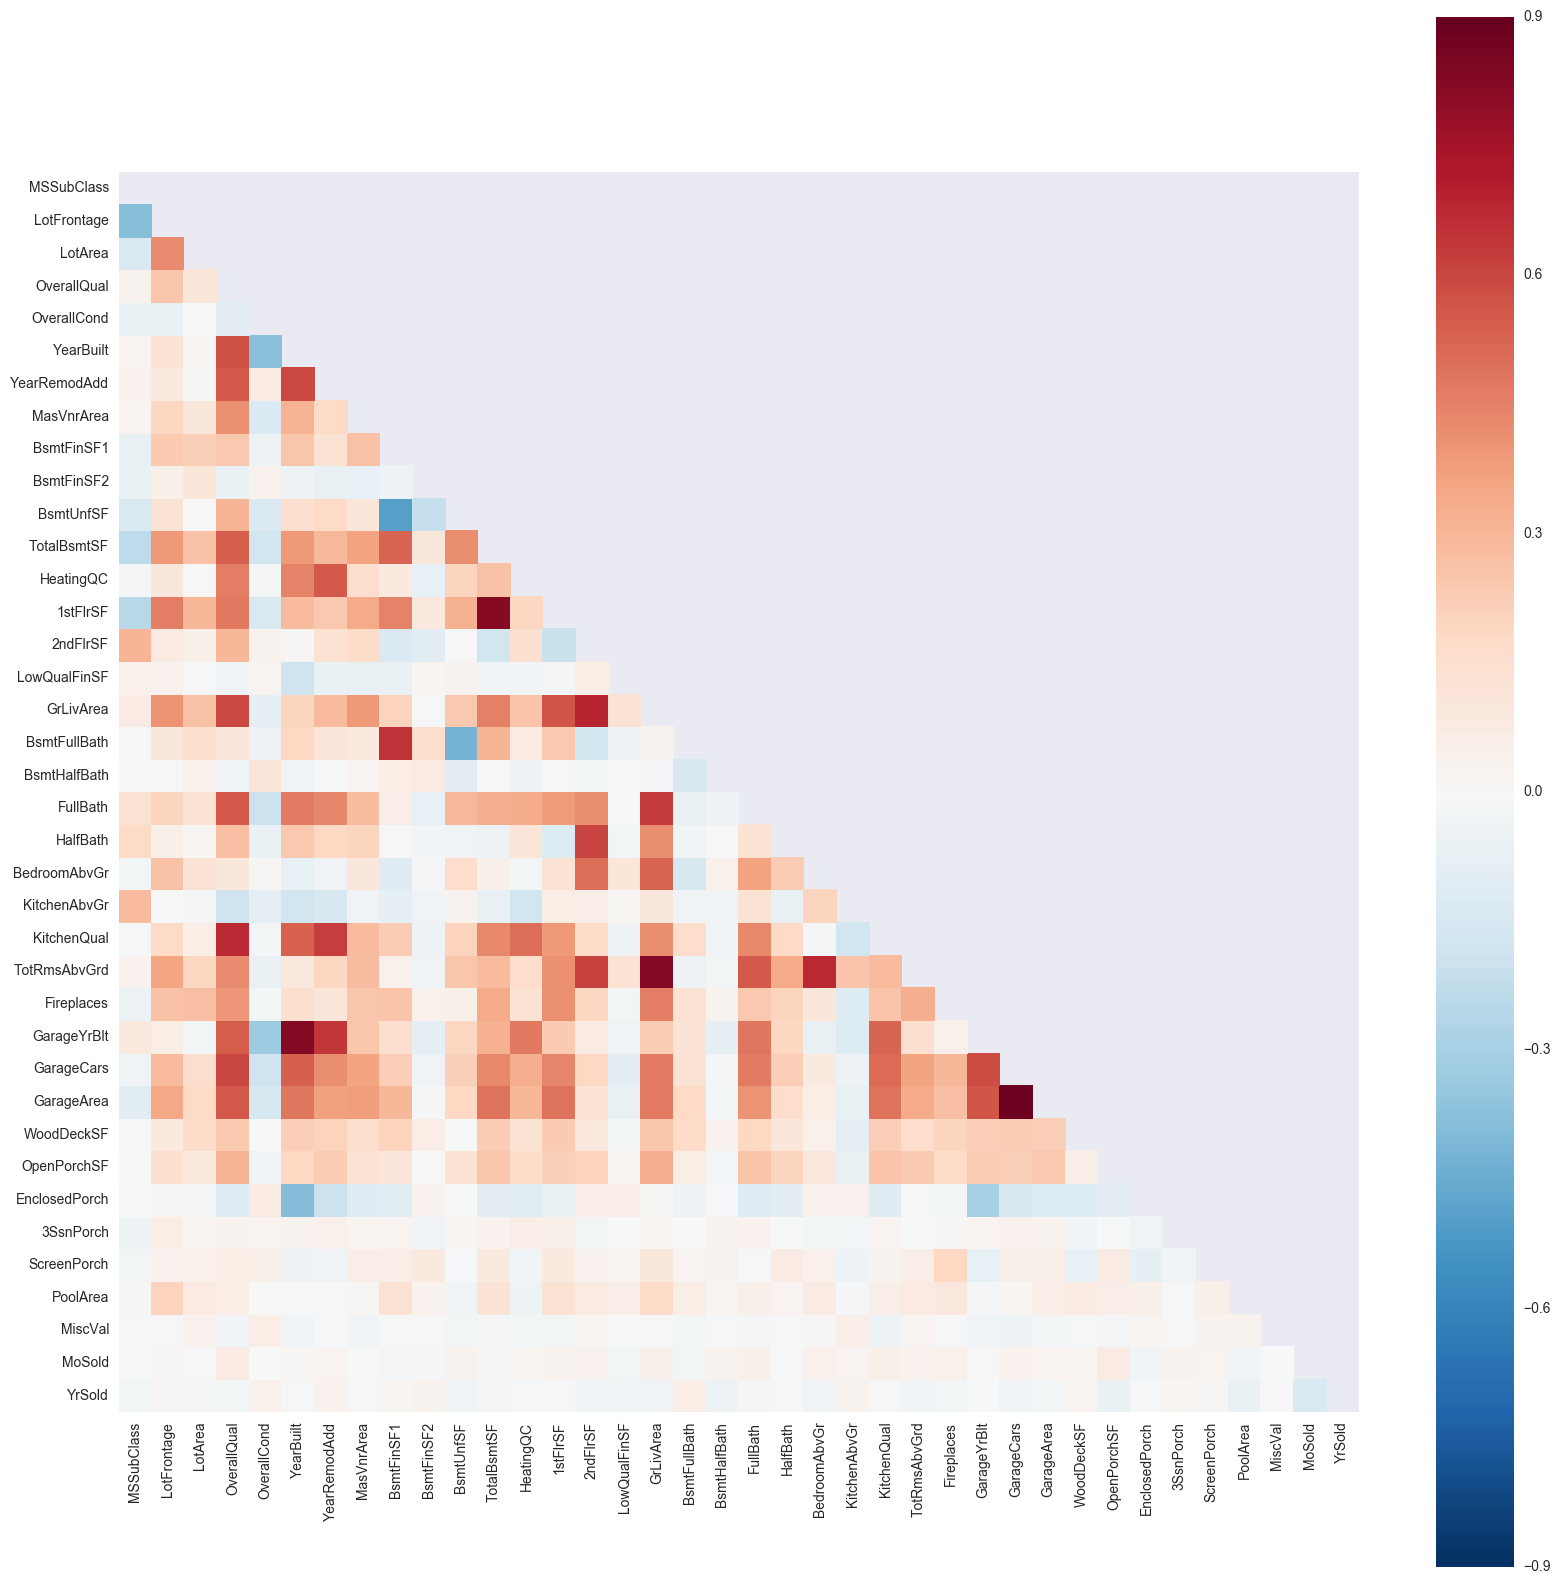

In [9]:
#We can calculate the correlation coefficients among variables and flag those with extremely high values
corr = df_quant[df_quant.columns[1:39]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(20,20))
plt.subplot2grid((1,1), (0,0))
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.9, square=True, annot=False)

### Calculation of the skewness and check for high values that could justify a transformation

In [10]:
#We can also calculate the skewness and notice that there are many variables
skew = df_quant[df_quant.columns[1:40]].skew()
print(skew)

MSSubClass        1.407657
LotFrontage       2.163569
LotArea          12.207688
OverallQual       0.216944
OverallCond       0.693067
YearBuilt        -0.613461
YearRemodAdd     -0.503562
MasVnrArea        2.669084
BsmtFinSF1        1.685503
BsmtFinSF2        4.255261
BsmtUnfSF         0.920268
TotalBsmtSF       1.524255
HeatingQC        -0.540458
1stFlrSF          1.376757
2ndFlrSF          0.813030
LowQualFinSF      9.011341
GrLivArea         1.366560
BsmtFullBath      0.596067
BsmtHalfBath      4.103403
FullBath          0.036562
HalfBath          0.675897
BedroomAbvGr      0.211790
KitchenAbvGr      4.488397
KitchenQual       0.386765
TotRmsAbvGrd      0.676341
Fireplaces        0.649565
GarageYrBlt      -0.649415
GarageCars       -0.342549
GarageArea        0.179981
WoodDeckSF        1.541376
OpenPorchSF       2.364342
EnclosedPorch     3.089872
3SsnPorch        10.304342
ScreenPorch       4.122214
PoolArea         14.828374
MiscVal          24.476794
MoSold            0.212053
Y

In [11]:
df_quant.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 40 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
HeatingQC        1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
K

In [12]:
#Function to eliminate columns with more than N null values and substitute null values in the remaining with median:
def null_value_treatment(dataframe, thresh_null):
    for col in dataframe.columns.values:
        if np.sum(dataframe[col].isnull()) > thresh_null:
            dataframe.drop(col, axis=1, inplace=True)
            print(col)
        elif np.sum(dataframe[col].isnull()) > 0:
            median = dataframe[col].median()
            idx = np.where(dataframe[col].isnull())[0]
            dataframe[col].iloc[idx] = median
    return

#We could do the same operation for the test dataset, but in reality, we want to keep the same number of predictors

In [13]:
null_value_treatment(df_quant, 150)
null_value_treatment(df_quant_test, 150)

LotFrontage


/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


LotFrontage


In [14]:
def transform_skew(dataframe, skew_thresh):
    for col in dataframe.columns.values: 
        if (dataframe[col].skew()) > skew_thresh:
            dataframe[col] = np.log(dataframe[col])
            dataframe[col] = dataframe[col].apply(lambda x: 0 if x == (-1*np.inf) else x)
#           df_quant[col] = Normalizer().fit_transform(df_quant[col].reshape(1,-1))[0]

transform_skew(df_quant, 1.0)
transform_skew(df_quant_test, 1.0)

In [15]:
def null_value_treatment_categorical(dataframe, thresh_null):
    for col in dataframe.columns.values:
        if np.sum(dataframe[col].isnull()) > thresh_null:
            dataframe.drop(col, axis=1, inplace=True)
            print(col)
        elif np.sum(dataframe[col].isnull()) > 0:
            dataframe[col] = dataframe[col].fillna('MIA', inplace=True)
    return

null_value_treatment_categorical(df_category, 150)
print('----------------')
null_value_treatment_categorical(df_category_test, 150)

/Users/Tavo/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/Tavo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Tavo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


FireplaceQu
Fence
----------------
FireplaceQu
Fence


#### We need to be careful to keep the same number of predictors in the train and tests datasets. Otherwise, the fitted model won't be useful for the test data. If we examine the shape of the dummy dataframes, we realise that they differ greatly. This is beacuase some values  within a predictor are not represented in the test dataset. To avoid this, we will merge the train and test dataset, then run the dummy variables, and then separate the datasets again. 

In [16]:
cat_variables = df_category.columns.values
cat_variables_test = df_category_test.columns.values

df_dummies = pd.get_dummies(df_category, columns=cat_variables)
df_dummies_test = pd.get_dummies(df_category_test, columns=cat_variables)

In [17]:
#Dummies are different size because of missing dimensions/values within some of the predictors
print(df_category.shape)
print('------------------')
print(df_category_test.shape)
print('------------------')
print(df_dummies.shape)
print('------------------')
print(df_dummies_test.shape)
print('------------------')
print(df_quant.shape) #one predictor more than test because it still contains the 'predicted' feature.
print('------------------')
print(df_quant_test.shape)

(1460, 36)
------------------
(1459, 36)
------------------
(1460, 173)
------------------
(1459, 113)
------------------
(1460, 39)
------------------
(1459, 38)


In [18]:
#Let's check if we have the same columns
print(df_category.columns)
df_category_test.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')


Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [19]:
#Here we have to merge categorical datasets, then run the dummies, then separate.
df_category_joint = pd.concat([df_category, df_category_test])
df_category_joint.shape

(2919, 36)

In [20]:
df_dummies_joint = pd.get_dummies(df_category_joint, columns=cat_variables, drop_first=True)
df_dummies_joint.shape

df_dummies = df_dummies_joint[0:1460]
df_dummies_test = df_dummies_joint[1460:2919]

In [21]:
#Let's verify...
print(df_dummies_joint[0:1460].shape)
print(df_dummies_joint[1460:2919].shape)

(1460, 151)
(1459, 151)


In [22]:
y_train = df_quant['SalePrice']

X_train = df_dummies.join(df_quant)
X_train = X_train.drop(['SalePrice', 'Id'], axis=1)

X_test = df_dummies_test.join(df_quant_test)
X_test = X_test.drop(['Id'], axis=1)

In [23]:
X_train.head()
X_train.shape

(1460, 188)

In [24]:
X_test.head()
X_test.shape

(1459, 188)

In [25]:
#---xxx---

#### We need to creat a dataset that is scaled and see how our predictions change_scale

In [30]:
saved_cols = X_train.columns.values
scaler = pp.StandardScaler(with_mean=True).fit(X_train)

X_train_scale = pd.DataFrame(scaler.transform(X_train), columns=saved_cols)
X_test_scale = pd.DataFrame(scaler.transform(X_train), columns=saved_cols)

In [32]:
X_train_scale.head()
X_test_scale.drop(X_test_scale.index[[1459]], inplace=True) #The scaler introduced an extra value at the end of the test dataframe
print(X_train_scale.shape, X_test_scale.shape)

(1460, 188) (1459, 188)


### Building a neural network


In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Compile a neural network
def create_model():
    model_nn1 = Sequential()
    model_nn1.add(Dense(input_dim=X_train_scale.shape[1], output_dim=100, init='uniform', activation='relu'))
    model_nn1.add(Dense(input_dim=100, output_dim=50, init='uniform', activation='relu'))
    model_nn1.add(Dense(input_dim=50, output_dim=30, init='uniform', activation='relu'))
    model_nn1.add(Dense(input_dim=30, output_dim=6, init='uniform', activation='relu'))
    model_nn1.add(Dense(6, init='uniform', activation='relu'))
    model_nn1.add(Dense(1, init='uniform', activation='relu'))
    # Compile model
    model_nn1.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model_nn1

In [ ]:
#Put the network into the Keras regressor
estimator = KerasRegressor(build_fn=create_model, nb_epoch=100, batch_size=1, verbose=0)

#### Let's define the folds and check the score...

In [ ]:
# Define folds for cross-validation
kf = cv.KFold(1460, n_folds=8, shuffle=True)
results = cv.cross_val_score(estimator, X_train_scale.values, y_train.values, cv=kf)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [36]:
estimator.fit(X_train_scale.values, y_train.values, validation_split=0.2)

In [37]:
y_test = estimator.predict(X_test_scale.values)

In [38]:
y_test
X_test_scale.shape

(1459, 188)

In [39]:
y = np.exp(y_test)

In [40]:
y

array([[ 166948.10735601],
       [ 136998.39053028],
       [ 140817.07405939],
       ..., 
       [ 408616.06300383],
       [  10995.14576017],
       [ 140107.91528857]])

In [ ]:
#Let's group some data...
train_diag = X_train_scale.join(np.exp(y_train))
train_diag['dataset'] = 'train'
train_diag['Id'] = realestate['Id']

test_diag = X_test_scale
test_diag['SalePrice'] = y
test_diag['dataset'] = 'test'
test_diag['Id'] = realestate_test['Id']

total_diag = pd.concat([train_diag, test_diag])

print(train_diag.shape, test_diag.shape, total_diag.shape)
test_diag.head()
#total_diag.columns.values


#### Output the predictions

In [ ]:
submission = test_diag[['Id', 'SalePrice']]
submission.Id = submission.Id.astype(int)
submission.to_csv("submission_realestate_tawonque_neural.csv", index=False) 
print('Done!')


In [ ]:
submission.head(10)